In [ ]:
!pip install thewalrus


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 83 kB 2.3 MB/s 


In [ ]:
from thewalrus import perm
from scipy.stats import unitary_group
from scipy.linalg import block_diag, sqrtm
import numpy as np
from math import factorial 
from math import acos, asin
import itertools as iter 
import matplotlib.pyplot as plt 
import numpy.ma as ma
from keras import models
from keras import layers

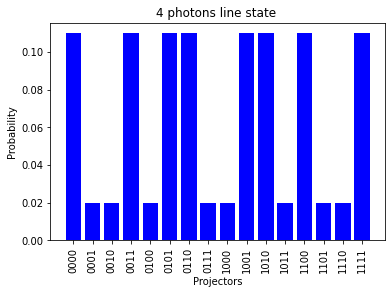

In [ ]:
# CREATING GRAPHS

# Creating example data from the supplementary information section of Programmable four-photon graph states on a silicon chip

num_labels = np.arange(0, 16, 1)

xlabels = ['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', 
           '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']

norm_probs = [1.1e-01, 0.2e-01, 0.2e-01, 1.1e-01,
 0.2e-01, 1.1e-01, 1.1e-01, 0.2e-01,
 0.2e-01, 1.1e-01, 1.1e-01, 0.2e-01,
 1.1e-01, 0.2e-01, 0.2e-01, 1.1e-01]


plt.bar(num_labels, norm_probs, color = 'blue')
plt.xlabel('Projectors')
plt.xticks(num_labels, labels=xlabels, rotation='vertical')
plt.ylabel('Probability')
plt.title('4 photons line state ')
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/ma/core.py:2830: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  order=order, subok=True, ndmin=ndmin)
/usr/local/lib/python3.7/dist-packages/numpy/lib/stride_tricks.py:536: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]


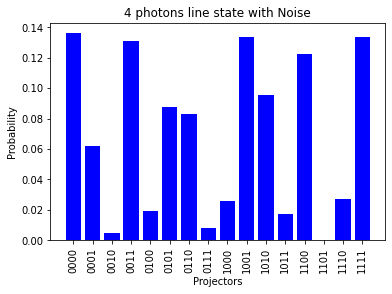

In [ ]:
# Lets take the case where we add noise. Trying random noise 
norm_probs = [1.1e-01, 0.2e-01, 0.2e-01, 1.1e-01,
 0.2e-01, 1.1e-01, 1.1e-01, 0.2e-01,
 0.2e-01, 1.1e-01, 1.1e-01, 0.2e-01,
 1.1e-01, 0.2e-01, 0.2e-01, 1.1e-01]

for i in range(len(norm_probs)):
    num = norm_probs[i]
    noise = np.random.normal(0,0.2e-1,1)
    #print(noise)
    
    norm_probs[i] = num + noise
    if norm_probs[i] < 0:
      norm_probs[i] = 0.1e-3

# Handling arrays for plotting
norm_noise = ma.masked_array(norm_probs, mask =[False])
#norm_noise = norm_probs[:,0]


plt.bar(num_labels, norm_noise, color = 'blue')
plt.xlabel('Projectors')
plt.xticks(num_labels, labels=xlabels, rotation='vertical')
plt.ylabel('Probability')
plt.title('4 photons line state with Noise')
plt.show()

In [ ]:
def graph_gen(): # Generates data with and without noise
  # Generating multiple 4 photon line states
  n_probs = []
  n_noise = []

  # Generating probability values for high and low states
  high = np.random.uniform(0.08, 0.15)
  low  = np.random.uniform(0.005, 0.04)

  for i in range(0, 16):
      var = np.random.randint(0,2)

      noise = np.random.normal(0,0.15e-1,1)
      noise = noise[0]

      # Determining if state is low or high
      if var == 1:
        n_probs.append(high)
        n_noise.append(high + noise)

      else:
        n_probs.append(low)
        if low + noise < 0:
          n_noise.append(0.1e-3)
        else:
          n_noise.append(low + noise)

  #fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
  #fig.suptitle('Normal Probabilty vs Noise')
  #ax1.bar(num_labels, n_probs, color = 'blue')
  #ax1.set_xticks(range(0,16))
  #ax1.set_xticklabels(xlabels, rotation=90)
  #ax2.bar(num_labels, n_noise, color = 'blue')
  #ax2.set_xticks(range(0,16))
  #ax2.set_xticklabels(xlabels, rotation=90)


  #for txt in fig.texts:
      #txt.set_visible(False)
  return n_probs, n_noise

In [ ]:
# Creating train and test data

train_target = [] # Without Noise
train_data = [] # With Noise
num_train = 40000 # number of training samples

# Generating data
for i in range(0,num_train):
  c, d = graph_gen()
  train_target.append(c)
  train_data.append(d)

#Converting to arrays
train_target = np.array(train_target)
train_data = np.array(train_data)

test_target = []
test_data = []
num_test = 1000

# Generating data
for i in range(0,num_test):
  c, d = graph_gen()
  test_target.append(c)
  test_data.append(d)

test_data = np.array(test_data)
test_target = np.array(test_target)

In [ ]:
# Algorithm to determine average deviation from train to real and corrected to real

def graph_diff(noise, corrected, target):
  diff_n = [] #difference between noise and target
  diff_c = [] #difference between corrected and targetr
  for i in range(0,len(noise)):
    diff_n.append( np.abs( noise[i] - target[i]))
    diff_c.append( np.abs( corrected[i] - target[i]))
  return np.mean(diff_n), np.mean(diff_c)

In [ ]:
# Prints percent improvement on each individual case
def diff_print(noise, corrected, target):
  a, b = graph_diff(noise, corrected, target)
  print( f"Mean difference test data: {round(a, 5)}. Mean difference in corrected data: {round(b, 5)} ")
  percent = (a - b)/ a * 100
  print(f"That is a {round(percent, 3)} % difference")

# Prints percent improvement across all test cases
def diff_all(noise, corrected, target, correct_bool=False):
  mean = [] 
  
  for i in range(0, len(target)):
    if correct_bool == True:
      corr_mean = mean_out(corrected[i])
    else:
      corr_mean = corrected[i]
    a, b = graph_diff(noise[i], corr_mean, target[i])
    mean.append((a - b)/a * 100)
  #print(mean)
  print(f"Total Improvement Percentage: {round(np.mean(mean), 2)}")

 # IMPLEMENTATION OF CLASSIC ALGORITHM
# Essentially sets all of high and low values to same value
def mean_out(data):
  maximum = np.max(data)
  minimum = np.min(data)
  midway = (maximum - minimum)/2
 
  hi = []
  lo = []
  vars = []
  for num in data:
    if num > midway:
      hi.append(num)
      vars.append(1)
    else: 
      lo.append(num)
      vars.append(0)

  hi_mean = np.mean(hi)
  lo_mean = np.mean(lo)
  
  output = []
  for i in vars:
    if i == 1:
      output.append(hi_mean)
    else: 
      output.append(lo_mean)
  return output

In [ ]:
from keras import models
from keras import layers
# Multi-variable output
model = models.Sequential()
model.add(layers.Dense(64, input_dim=16, activation="relu"))
model.add(layers.Dense(32, activation="relu"))
#model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(16, activation=None))
model.compile(loss="mse", optimizer='rmsprop')

history = model.fit(train_data, train_target , epochs=200, batch_size=20, verbose=1)

plt.plot(history.history['loss'])

Total Improvement Percentage: 53.14
Mean difference test data: 0.01096. Mean difference in corrected data: 0.00435 
That is a 60.304 % difference
Mean difference test data: 0.00679. Mean difference in corrected data: 0.0053 
That is a 21.878 % difference
Mean difference test data: 0.008. Mean difference in corrected data: 0.00401 
That is a 49.868 % difference
Mean difference test data: 0.01165. Mean difference in corrected data: 0.00439 
That is a 62.334 % difference
Mean difference test data: 0.01345. Mean difference in corrected data: 0.00792 
That is a 41.119 % difference


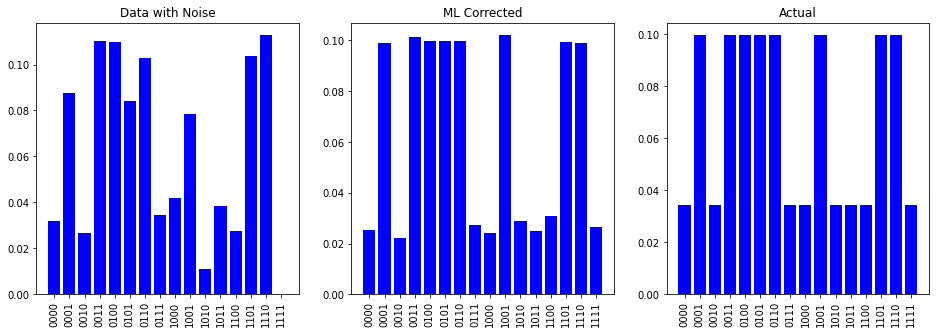

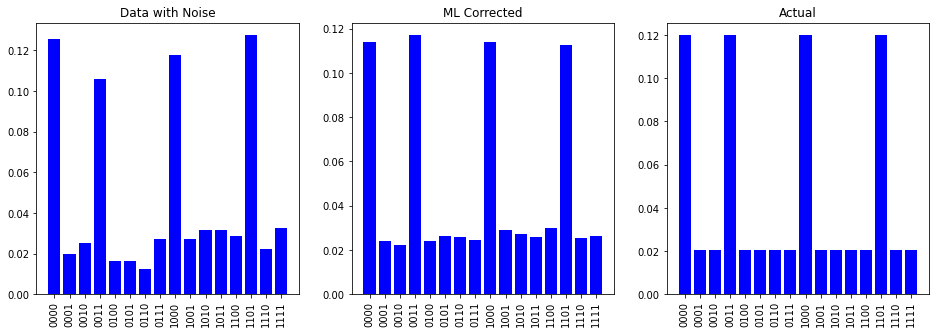

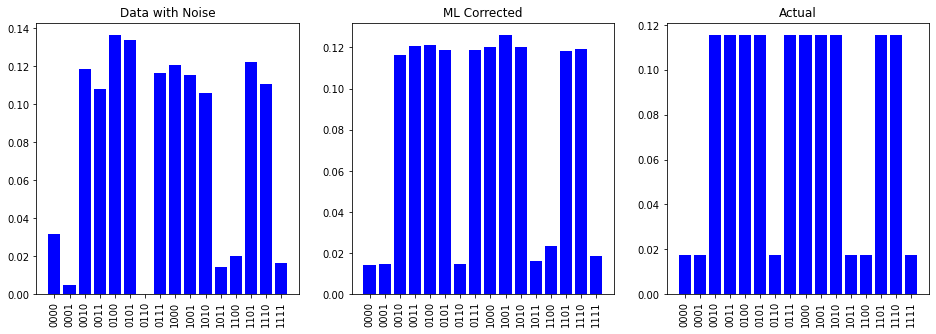

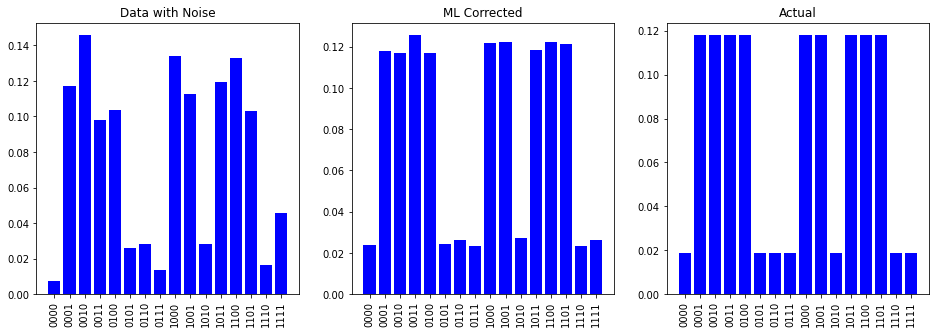

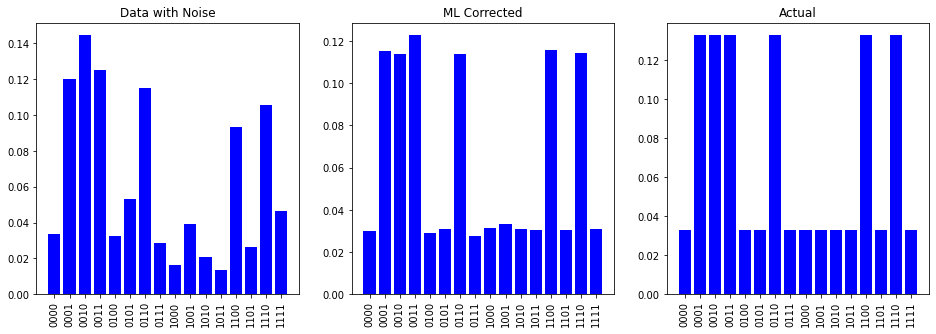

In [ ]:
coding = model.predict(test_data)
diff_all(test_data, coding, test_target)
for i in range(0,5):
  diff_print(test_data[i], coding[i], test_target[i])
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,5))
  fig.suptitle('Noised reducee vs original')
  ax1.bar(num_labels, test_data[i], color = 'blue')
  ax1.set_xticks(range(0,16))
  ax1.set_xticklabels(xlabels, rotation=90)
  ax2.bar(num_labels, coding[i], color = 'blue')
  ax2.set_xticks(range(0,16))
  ax2.set_xticklabels(xlabels, rotation=90)
  ax3.bar(num_labels, test_target[i], color = 'blue')
  ax3.set_xticks(range(0,16))
  ax3.set_xticklabels(xlabels, rotation=90)
  ax1.title.set_text('Data with Noise')
  ax2.title.set_text('ML Corrected')
  ax3.title.set_text('Actual')  

  for txt in fig.texts:
    txt.set_visible(False)

In [ ]:
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 128)               2176      
                                                                 
 dense_17 (Dense)            (None, 64)                8256      
                                                                 
 dense_18 (Dense)            (None, 16)                1040      
                                                                 
Total params: 11,472
Trainable params: 11,472
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.save("f55.84") 

INFO:tensorflow:Assets written to: f55.84/assets


In [ ]:
# PRELOADED MODELS

# Models availabe (4000 training data)
# fiftynine: 500 epochs, 20 batches - 35% improvement
# fiftyfour: 1000 epochs, 20 batches - 54% improvement
# fiftyfive: 2000 epochs, 20 batches - 55% improvement
# Layer12864: 1000 epochs, 20 bathces - 48% improvement
# 40,000 training data, 1000 testing
# f55.84: 200 epochs, 20 batches - 55% improvement

model = models.load_model('fiftyfive')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                1088      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 16)                528       
                                                                 
Total params: 3,696
Trainable params: 3,696
Non-trainable params: 0
_________________________________________________________________


Total Improvement Percentage: 53.14


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Total Improvement Percentage: 34.87
Mean difference test data: 0.01096. Mean difference in corrected data: 0.00435 
That is a 60.304 % difference
Mean difference test data: 0.00679. Mean difference in corrected data: 0.0053 
That is a 21.878 % difference
Mean difference test data: 0.008. Mean difference in corrected data: 0.00401 
That is a 49.868 % difference
Mean difference test data: 0.01165. Mean difference in corrected data: 0.00439 
That is a 62.334 % difference
Mean difference test data: 0.01345. Mean difference in corrected data: 0.00792 
That is a 41.119 % difference


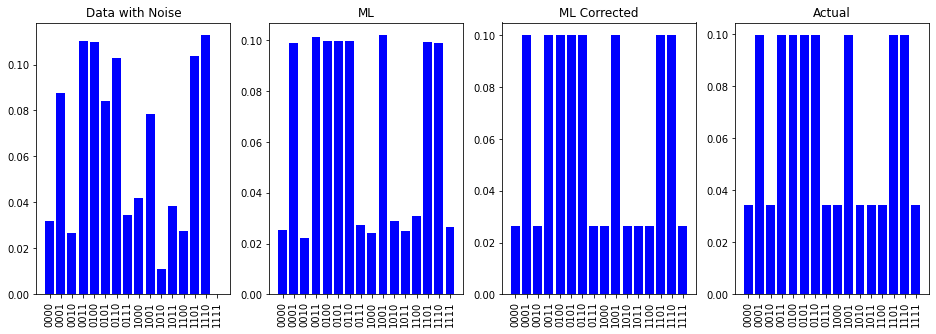

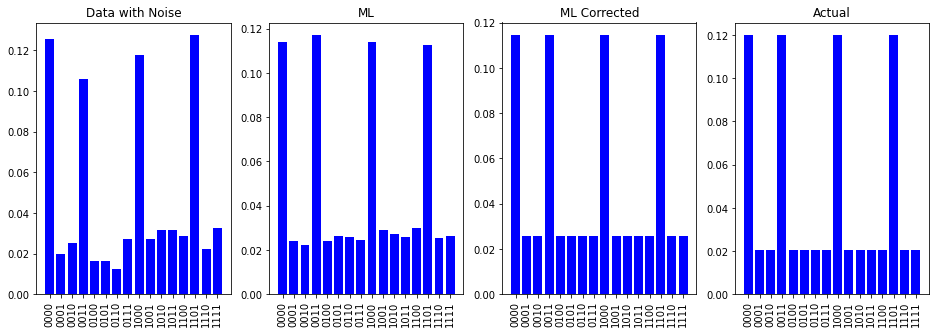

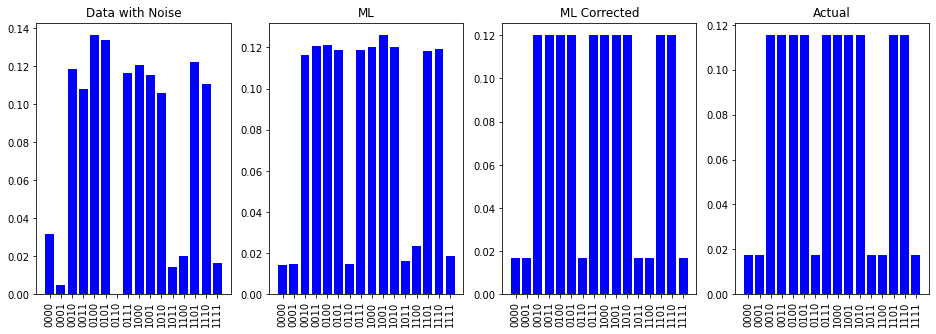

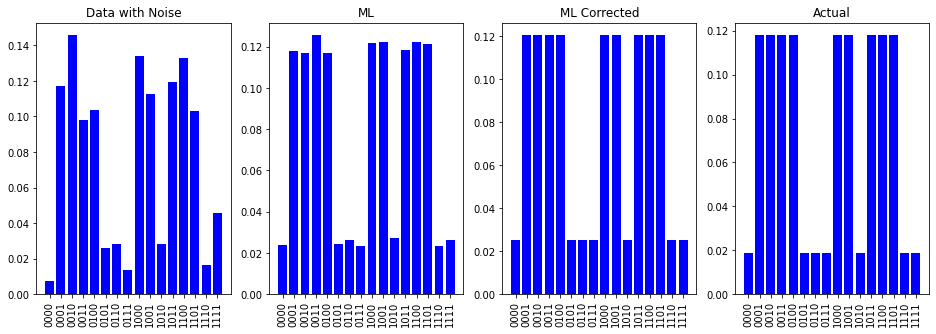

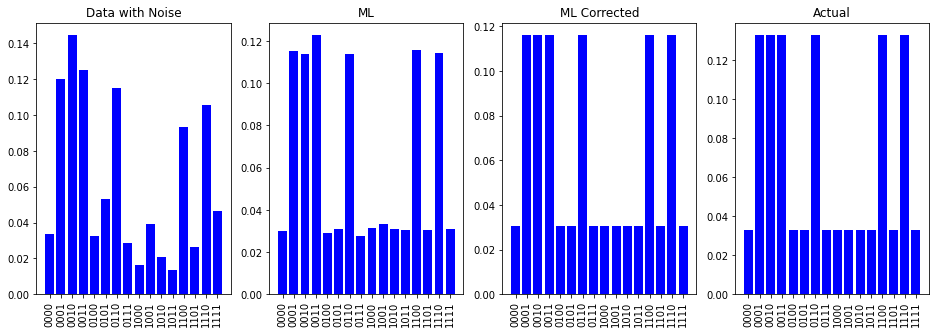

In [ ]:
# PRINT CODE 2
# Includes classic algorithm 

coding = model.predict(test_data)
diff_all(test_data, coding, test_target)
diff_all(test_data, coding, test_target, correct_bool=True)
for i in range(0,5):
  diff_print(test_data[i], coding[i], test_target[i])
  fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16,5))
  fig.suptitle('Noised reducee vs original')
  ax1.bar(num_labels, test_data[i], color = 'blue')
  ax1.set_xticks(range(0,16))
  ax1.set_xticklabels(xlabels, rotation=90)
  ax2.bar(num_labels, coding[i], color = 'blue')
  ax2.set_xticks(range(0,16))
  ax2.set_xticklabels(xlabels, rotation=90)
  ax3.bar(num_labels, mean_out(coding[i]), color = 'blue')
  ax3.set_xticks(range(0,16))
  ax3.set_xticklabels(xlabels, rotation=90)
  ax4.bar(num_labels, test_target[i], color = 'blue')
  ax4.set_xticks(range(0,16))
  ax4.set_xticklabels(xlabels, rotation=90)
  ax1.title.set_text('Data with Noise')
  ax2.title.set_text('ML')
  ax3.title.set_text('ML Corrected')  
  ax4.title.set_text('Actual')

  for txt in fig.texts:
    txt.set_visible(False)